In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.graph_objects as go
import seaborn as sns

In [2]:
dfd = pd.read_csv(r'C:\Users\arceb\PycharmProjects\pythonProject/Paris_.csv', index_col = 0)

C:\Users\arceb\AppData\Local\Temp\ipykernel_53960\3040532099.py:1: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  dfd = pd.read_csv(r'C:\Users\arceb\PycharmProjects\pythonProject/Paris_.csv', index_col = 0)


In [417]:
dfd=dfd.rename(columns={'Type de ressource\n': 'Type'})
dfd

,Numéro Unique,Ressources mensuelles\n,Type,Montant par type de ressource\n
0,0010217076044GDPUB,1890.0,Allocation chômage / indemnités,1890.0
1,001031606377111126,1550.0,Salaire ou revenu d'activité,1550.0
2,001031707760010107,800.0,Allocation de minimum vieillesse,200.0
3,001031707760010107,800.0,Retraite,600.0
4,001031707857611126,592.0,Revenu de solidarité active (RSA),592.0
...,...,...,...,...
156570,9741217157742GDPUB,359.0,Allocation chômage / indemnités,185.0
156571,9741217157742GDPUB,359.0,Salaire ou revenu d'activité,174.0
156572,9741217157996GDPUB,680.0,Salaire ou revenu d'activité,680.0
156573,9760317000005GDPUB,NaN,NaN,NaN


In [418]:
dfd['Ressources mensuelles\n'].isna().sum()

1997

In [419]:
dfdbis=dfd.drop_duplicates(subset ="Numéro Unique")
dfdbis=dfdbis.dropna()
dfdbis

,Numéro Unique,Ressources mensuelles\n,Type,Montant par type de ressource\n
0,0010217076044GDPUB,1890.0,Allocation chômage / indemnités,1890.0
1,001031606377111126,1550.0,Salaire ou revenu d'activité,1550.0
2,001031707760010107,800.0,Allocation de minimum vieillesse,200.0
4,001031707857611126,592.0,Revenu de solidarité active (RSA),592.0
5,001031707895818214,472.0,Allocation chômage / indemnités,0.0
...,...,...,...,...
156564,974061714677811483,806.0,Salaire ou revenu d'activité,806.0
156565,974061714796911487,2699.0,Allocation familiales,1193.0
156569,9740917152615GDPUB,184.0,Allocation Jeune Enfant (PAJE),184.0
156570,9741217157742GDPUB,359.0,Allocation chômage / indemnités,185.0


### Calcul des ressources imposables mensuelles

In [420]:
values=["Retraite", "Allocation chômage / indemnités", "Salaire ou revenu d'activité", "Pension alimentaire reçue", "Autres (hors APL ou AL)", "Pension d\'invalidité"]
filtered_df = dfd[dfd.Type.isin(values)]
filtered_df

,Numéro Unique,Ressources mensuelles\n,Type,Montant par type de ressource\n
0,0010217076044GDPUB,1890.0,Allocation chômage / indemnités,1890.0
1,001031606377111126,1550.0,Salaire ou revenu d'activité,1550.0
3,001031707760010107,800.0,Retraite,600.0
5,001031707895818214,472.0,Allocation chômage / indemnités,0.0
12,001031707895818214,472.0,Autres (hors APL ou AL),0.0
...,...,...,...,...
156564,974061714677811483,806.0,Salaire ou revenu d'activité,806.0
156567,974061714796911487,2699.0,Autres (hors APL ou AL),767.0
156570,9741217157742GDPUB,359.0,Allocation chômage / indemnités,185.0
156571,9741217157742GDPUB,359.0,Salaire ou revenu d'activité,174.0


In [421]:
shrank_values = filtered_df.groupby(by='Numéro Unique').sum()['Montant par type de ressource\n']

merged_df = filtered_df.merge(shrank_values, left_on='Numéro Unique', right_index=True)

merged_df = merged_df.rename(columns={'Montant par type de ressource\n_y': 'Ressources imposables mensuelles moyennes (RI)'})


In [422]:
merged_df

,Numéro Unique,Ressources mensuelles\n,Type,Montant par type de ressource\n_x,Ressources imposables mensuelles moyennes (RI)
0,0010217076044GDPUB,1890.0,Allocation chômage / indemnités,1890.0,1890.0
1,001031606377111126,1550.0,Salaire ou revenu d'activité,1550.0,1550.0
3,001031707760010107,800.0,Retraite,600.0,600.0
5,001031707895818214,472.0,Allocation chômage / indemnités,0.0,0.0
12,001031707895818214,472.0,Autres (hors APL ou AL),0.0,0.0
...,...,...,...,...,...
156564,974061714677811483,806.0,Salaire ou revenu d'activité,806.0,806.0
156567,974061714796911487,2699.0,Autres (hors APL ou AL),767.0,767.0
156570,9741217157742GDPUB,359.0,Allocation chômage / indemnités,185.0,359.0
156571,9741217157742GDPUB,359.0,Salaire ou revenu d'activité,174.0,359.0


In [423]:
merged_dfbis=merged_df.drop_duplicates(subset ="Numéro Unique")
merged_dfbis

,Numéro Unique,Ressources mensuelles\n,Type,Montant par type de ressource\n_x,Ressources imposables mensuelles moyennes (RI)
0,0010217076044GDPUB,1890.0,Allocation chômage / indemnités,1890.0,1890.0
1,001031606377111126,1550.0,Salaire ou revenu d'activité,1550.0,1550.0
3,001031707760010107,800.0,Retraite,600.0,600.0
5,001031707895818214,472.0,Allocation chômage / indemnités,0.0,0.0
21,0010517080269GDPUB,2745.0,Autres (hors APL ou AL),622.0,622.0
...,...,...,...,...,...
156562,9740617145543GDPUB,2150.0,Salaire ou revenu d'activité,2150.0,2150.0
156564,974061714677811483,806.0,Salaire ou revenu d'activité,806.0,806.0
156567,974061714796911487,2699.0,Autres (hors APL ou AL),767.0,767.0
156570,9741217157742GDPUB,359.0,Allocation chômage / indemnités,185.0,359.0


In [424]:
bdd = dfdbis.merge(merged_dfbis, on='Numéro Unique', how='outer')
bdd=bdd[['Numéro Unique', 'Ressources mensuelles\n_x','Ressources imposables mensuelles moyennes (RI)']]
bdd=bdd.rename(columns={'Ressources mensuelles\n_x': 'RM Moyennes'})
bdd

,Numéro Unique,RM Moyennes,Ressources imposables mensuelles moyennes (RI)
0,0010217076044GDPUB,1890.0,1890.0
1,001031606377111126,1550.0,1550.0
2,001031707760010107,800.0,600.0
3,001031707857611126,592.0,NaN
4,001031707895818214,472.0,0.0
...,...,...,...
77724,974061714677811483,806.0,806.0
77725,974061714796911487,2699.0,767.0
77726,9740917152615GDPUB,184.0,NaN
77727,9741217157742GDPUB,359.0,359.0


In [425]:
#Foyers dont les ressources mensuelles ne matchent pas le revenu imposable => Une part des ressources n'est pas imposable
merged_df[merged_df['Revenu imposable']!=merged_df['Ressources mensuelles']]

KeyError: 'Revenu imposable'

In [328]:
#Foyers avec plusieurs type de revenus
merged_df[merged_df['Revenu imposable']!=merged_df['Montant par type de ressource_x']]


KeyError: 'Revenu imposable'

In [329]:
#Foyers avec un seul type de revenu
merged_df[~(merged_df['Revenu imposable']!=merged_df['Montant par type de ressource_x'])]


KeyError: 'Revenu imposable'

### Calcul des prestations familiales et sociales mensuelles

In [426]:
values1=["Allocation d'adulte handicapé(AAH)", "Allocation d'éducation d'enfant handicapé (AEEH)", "Allocation de minimum vieillesse", "Allocation familiales", "Allocation Jeune Enfant (PAJE)", "Bourse étudiant", "Prime d'activité", "Revenu de solidarité active (RSA)", "Allocation journalière de présence parentale (AJPP)"]
filtered_df1 = dfd[dfd.Type.isin(values1)]
filtered_df1

,Numéro Unique,Ressources mensuelles\n,Type,Montant par type de ressource\n
2,001031707760010107,800.0,Allocation de minimum vieillesse,200.0
4,001031707857611126,592.0,Revenu de solidarité active (RSA),592.0
6,001031707895818214,472.0,Allocation d'adulte handicapé(AAH),0.0
7,001031707895818214,472.0,Allocation d'éducation d'enfant handicapé (AEEH),0.0
8,001031707895818214,472.0,Allocation de minimum vieillesse,0.0
...,...,...,...,...
156563,974061714628311487,808.0,Allocation d'adulte handicapé(AAH),808.0
156565,974061714796911487,2699.0,Allocation familiales,1193.0
156566,974061714796911487,2699.0,Allocation Jeune Enfant (PAJE),184.0
156568,974061714796911487,2699.0,Revenu de solidarité active (RSA),555.0


In [427]:
shrank_values1 = filtered_df1.groupby(by='Numéro Unique').sum()['Montant par type de ressource\n']

merged_df1 = filtered_df1.merge(shrank_values1, left_on='Numéro Unique', right_index=True)

merged_df1 = merged_df1.rename(columns={'Montant par type de ressource\n_y': 'Prestations familiales et sociales mensuelles moyennes (PFS)'})

In [428]:
merged_df1

,Numéro Unique,Ressources mensuelles\n,Type,Montant par type de ressource\n_x,Prestations familiales et sociales mensuelles moyennes (PFS)
2,001031707760010107,800.0,Allocation de minimum vieillesse,200.0,200.0
4,001031707857611126,592.0,Revenu de solidarité active (RSA),592.0,592.0
6,001031707895818214,472.0,Allocation d'adulte handicapé(AAH),0.0,472.0
7,001031707895818214,472.0,Allocation d'éducation d'enfant handicapé (AEEH),0.0,472.0
8,001031707895818214,472.0,Allocation de minimum vieillesse,0.0,472.0
...,...,...,...,...,...
156563,974061714628311487,808.0,Allocation d'adulte handicapé(AAH),808.0,808.0
156565,974061714796911487,2699.0,Allocation familiales,1193.0,1932.0
156566,974061714796911487,2699.0,Allocation Jeune Enfant (PAJE),184.0,1932.0
156568,974061714796911487,2699.0,Revenu de solidarité active (RSA),555.0,1932.0


In [429]:
merged_dfbis1=merged_df1.drop_duplicates(subset ="Numéro Unique")
merged_dfbis1

,Numéro Unique,Ressources mensuelles\n,Type,Montant par type de ressource\n_x,Prestations familiales et sociales mensuelles moyennes (PFS)
2,001031707760010107,800.0,Allocation de minimum vieillesse,200.0,200.0
4,001031707857611126,592.0,Revenu de solidarité active (RSA),592.0,592.0
6,001031707895818214,472.0,Allocation d'adulte handicapé(AAH),0.0,472.0
19,0010517080269GDPUB,2745.0,Allocation familiales,922.0,2123.0
23,001061201540711126,2522.0,Allocation familiales,662.0,662.0
...,...,...,...,...,...
156556,9730416028012GDPUB,834.0,Revenu de solidarité active (RSA),834.0,834.0
156561,9740415090472GDPUB,471.0,Revenu de solidarité active (RSA),471.0,471.0
156563,974061714628311487,808.0,Allocation d'adulte handicapé(AAH),808.0,808.0
156565,974061714796911487,2699.0,Allocation familiales,1193.0,1932.0


In [430]:
bddbis = bdd.merge(merged_dfbis1, on='Numéro Unique', how='outer')
bddbis=bddbis.rename(columns={'Ressources mensuelles\n_x': 'RM Moyennes'})
bddbis=bddbis[['Numéro Unique', 'RM Moyennes','Ressources imposables mensuelles moyennes (RI)', 'Prestations familiales et sociales mensuelles moyennes (PFS)']]
bddbis

,Numéro Unique,RM Moyennes,Ressources imposables mensuelles moyennes (RI),Prestations familiales et sociales mensuelles moyennes (PFS)
0,0010217076044GDPUB,1890.0,1890.0,NaN
1,001031606377111126,1550.0,1550.0,NaN
2,001031707760010107,800.0,600.0,200.0
3,001031707857611126,592.0,NaN,592.0
4,001031707895818214,472.0,0.0,472.0
...,...,...,...,...
77724,974061714677811483,806.0,806.0,NaN
77725,974061714796911487,2699.0,767.0,1932.0
77726,9740917152615GDPUB,184.0,NaN,184.0
77727,9741217157742GDPUB,359.0,359.0,NaN


In [431]:
bddbis['Ressources imposables mensuelles moyennes (RI)'].isna().sum()

13566

In [432]:
bddbis['Prestations familiales et sociales mensuelles moyennes (PFS)'].isna().sum()

38719

### Somme Revenus imposables et prestations

In [433]:
bddbis['Ressources imposables mensuelles moyennes (RI)'].fillna(0, inplace=True)
bddbis['Prestations familiales et sociales mensuelles moyennes (PFS)'].fillna(0, inplace=True)

In [434]:
bddbis

,Numéro Unique,RM Moyennes,Ressources imposables mensuelles moyennes (RI),Prestations familiales et sociales mensuelles moyennes (PFS)
0,0010217076044GDPUB,1890.0,1890.0,0.0
1,001031606377111126,1550.0,1550.0,0.0
2,001031707760010107,800.0,600.0,200.0
3,001031707857611126,592.0,0.0,592.0
4,001031707895818214,472.0,0.0,472.0
...,...,...,...,...
77724,974061714677811483,806.0,806.0,0.0
77725,974061714796911487,2699.0,767.0,1932.0
77726,9740917152615GDPUB,184.0,0.0,184.0
77727,9741217157742GDPUB,359.0,359.0,0.0


In [435]:
bddbis['Ri + PFS']=bddbis['Ressources imposables mensuelles moyennes (RI)']+bddbis['Prestations familiales et sociales mensuelles moyennes (PFS)']
bddbis

,Numéro Unique,RM Moyennes,Ressources imposables mensuelles moyennes (RI),Prestations familiales et sociales mensuelles moyennes (PFS),Ri + PFS
0,0010217076044GDPUB,1890.0,1890.0,0.0,1890.0
1,001031606377111126,1550.0,1550.0,0.0,1550.0
2,001031707760010107,800.0,600.0,200.0,800.0
3,001031707857611126,592.0,0.0,592.0,592.0
4,001031707895818214,472.0,0.0,472.0,472.0
...,...,...,...,...,...
77724,974061714677811483,806.0,806.0,0.0,806.0
77725,974061714796911487,2699.0,767.0,1932.0,2699.0
77726,9740917152615GDPUB,184.0,0.0,184.0,184.0
77727,9741217157742GDPUB,359.0,359.0,0.0,359.0


In [408]:
file_name = 'RI_PFS_IDF.csv'
bddbis.to_csv(file_name)

 ### Mise en place des tranches de ressources mensuelles

In [342]:
bddbis['Tranches de ressources mensuelles (RM)']=0

def decoupe(rl):
    for i in range(0, 5000, 50):
        if i<=rl and rl<i+50:
            return i
        elif rl>4950:
            return 4950

bddbis['Tranches de ressources mensuelles (RM)'] = bddbis['RM Moyennes'].apply(decoupe)
bddbis

,Numéro Unique,RM Moyennes,Ressources imposables mensuelles moyennes (RI),Prestations familiales et sociales mensuelles moyennes (PFS),Ri + PFS,Tranches de ressources mensuelles (RM)
0,001011403466511146,2134.0,1710.0,424.0,2134.0,2100.0
1,0010117074877GDPUB,900.0,200.0,700.0,900.0,900.0
2,001021504965918214,944.0,0.0,944.0,944.0,900.0
3,0010217076033GDPUB,1200.0,1200.0,0.0,1200.0,1200.0
4,001021707620301173,1200.0,1200.0,0.0,1200.0,1200.0
...,...,...,...,...,...,...
80874,9741117155529GDPUB,674.0,0.0,674.0,674.0,650.0
80875,974111715873511487,1725.0,1725.0,0.0,1725.0,1700.0
80876,9741216133916GDPUB,2000.0,2000.0,0.0,2000.0,2000.0
80877,9741216133920GDPUB,846.0,846.0,0.0,846.0,800.0


In [343]:
#bddbis['Tranches de ressources mensuelles'].dropna()

In [344]:
#bddbis.groupby(['Tranches de ressources mensuelles'])['Sales'].mean()
x=bddbis.groupby('Tranches de ressources mensuelles (RM)').mean().reset_index()
x

,Tranches de ressources mensuelles (RM),RM Moyennes,Ressources imposables mensuelles moyennes (RI),Prestations familiales et sociales mensuelles moyennes (PFS),Ri + PFS
0,0.0,1.844898,8.728571,1.648980,10.377551
1,50.0,78.186441,44.728814,42.796610,87.525424
2,100.0,118.508333,60.208333,86.941667,147.150000
3,150.0,176.809322,47.131356,134.745763,181.877119
4,200.0,218.787234,149.489362,84.581560,234.070922
...,...,...,...,...,...
94,4750.0,4771.400000,1611.600000,3159.800000,4771.400000
95,4800.0,4800.000000,4800.000000,0.000000,4800.000000
96,4850.0,4861.000000,4861.000000,0.000000,4861.000000
97,4900.0,4936.000000,4014.000000,922.000000,4936.000000


In [345]:
#x['Nombre de demandeurs'] = bddbis.groupby('Tranches de ressources mensuelles').count()
y=bddbis['Tranches de ressources mensuelles (RM)'].value_counts()
y=y.reset_index()
y

,index,Tranches de ressources mensuelles (RM)
0,800.0,5280
1,1200.0,3785
2,450.0,3773
3,1300.0,3352
4,900.0,3186
...,...,...
94,4800.0,2
95,4900.0,2
96,4450.0,2
97,4600.0,2


In [346]:
y=y.rename(columns={'index': 'Tranches de ressources mensuelles (RM)', "Tranches de ressources mensuelles (RM)": "Nombre de demandeurs"})

In [347]:
y

,Tranches de ressources mensuelles (RM),Nombre de demandeurs
0,800.0,5280
1,1200.0,3785
2,450.0,3773
3,1300.0,3352
4,900.0,3186
...,...,...
94,4800.0,2
95,4900.0,2
96,4450.0,2
97,4600.0,2


In [348]:
final = x.merge(y, on='Tranches de ressources mensuelles (RM)', how='left')
final

,Tranches de ressources mensuelles (RM),RM Moyennes,Ressources imposables mensuelles moyennes (RI),Prestations familiales et sociales mensuelles moyennes (PFS),Ri + PFS,Nombre de demandeurs
0,0.0,1.844898,8.728571,1.648980,10.377551,490
1,50.0,78.186441,44.728814,42.796610,87.525424,59
2,100.0,118.508333,60.208333,86.941667,147.150000,240
3,150.0,176.809322,47.131356,134.745763,181.877119,236
4,200.0,218.787234,149.489362,84.581560,234.070922,141
...,...,...,...,...,...,...
94,4750.0,4771.400000,1611.600000,3159.800000,4771.400000,5
95,4800.0,4800.000000,4800.000000,0.000000,4800.000000,2
96,4850.0,4861.000000,4861.000000,0.000000,4861.000000,1
97,4900.0,4936.000000,4014.000000,922.000000,4936.000000,2


In [349]:
final=final[['Tranches de ressources mensuelles (RM)', 'Nombre de demandeurs', 'RM Moyennes', 'Prestations familiales et sociales mensuelles moyennes (PFS)', 'Ressources imposables mensuelles moyennes (RI)', 'Ri + PFS']]

In [350]:
final=final.reset_index(drop=True)
final

,Tranches de ressources mensuelles (RM),Nombre de demandeurs,RM Moyennes,Prestations familiales et sociales mensuelles moyennes (PFS),Ressources imposables mensuelles moyennes (RI),Ri + PFS
0,0.0,490,1.844898,1.648980,8.728571,10.377551
1,50.0,59,78.186441,42.796610,44.728814,87.525424
2,100.0,240,118.508333,86.941667,60.208333,147.150000
3,150.0,236,176.809322,134.745763,47.131356,181.877119
4,200.0,141,218.787234,84.581560,149.489362,234.070922
...,...,...,...,...,...,...
94,4750.0,5,4771.400000,3159.800000,1611.600000,4771.400000
95,4800.0,2,4800.000000,0.000000,4800.000000,4800.000000
96,4850.0,1,4861.000000,0.000000,4861.000000,4861.000000
97,4900.0,2,4936.000000,922.000000,4014.000000,4936.000000


In [351]:
#file_name = 'Analyse des ressources v4.xlsx'
#final.to_excel(file_name)

### Tableaux croisés RI / PFS

In [352]:
bddbis['Tranches de RI']=0
bddbis['Tranches de PFS']=0

def decoupe2(rl):
    for i in range(0, 2000, 50):
        if i<rl and rl<=i+50:
            return i
        elif rl>2000:
            return np.NaN
        elif rl==0:
            return np.NaN


bddbis['Tranches de RI'] = bddbis['Ressources imposables mensuelles moyennes (RI)'].apply(decoupe2)
bddbis['Tranches de PFS'] = bddbis['Prestations familiales et sociales mensuelles moyennes (PFS)'].apply(decoupe2)
bddbis

,Numéro Unique,RM Moyennes,Ressources imposables mensuelles moyennes (RI),Prestations familiales et sociales mensuelles moyennes (PFS),Ri + PFS,Tranches de ressources mensuelles (RM),Tranches de RI,Tranches de PFS
0,001011403466511146,2134.0,1710.0,424.0,2134.0,2100.0,1700.0,400.0
1,0010117074877GDPUB,900.0,200.0,700.0,900.0,900.0,150.0,650.0
2,001021504965918214,944.0,0.0,944.0,944.0,900.0,NaN,900.0
3,0010217076033GDPUB,1200.0,1200.0,0.0,1200.0,1200.0,1150.0,NaN
4,001021707620301173,1200.0,1200.0,0.0,1200.0,1200.0,1150.0,NaN
...,...,...,...,...,...,...,...,...
80874,9741117155529GDPUB,674.0,0.0,674.0,674.0,650.0,NaN,650.0
80875,974111715873511487,1725.0,1725.0,0.0,1725.0,1700.0,1700.0,NaN
80876,9741216133916GDPUB,2000.0,2000.0,0.0,2000.0,2000.0,1950.0,NaN
80877,9741216133920GDPUB,846.0,846.0,0.0,846.0,800.0,800.0,NaN


In [353]:
tableau=bddbis[['Tranches de RI', 'Tranches de PFS']]
tableau=tableau.dropna()
tableau

,Tranches de RI,Tranches de PFS
0,1700.0,400.0
1,150.0,650.0
9,300.0,750.0
11,450.0,700.0
14,200.0,600.0
...,...,...
80864,1150.0,150.0
80867,1550.0,100.0
80868,350.0,1200.0
80870,700.0,200.0


In [354]:
#bddbis.pivot_table(index="Trancges de RI", columns="Tranches de PFS", values="value", aggfunc="sum")
z=bddbis.pivot_table(index="Tranches de RI", columns="Tranches de PFS", values="Numéro Unique",  aggfunc="size", fill_value=0)
z

Tranches de PFS,0.0,50.0,100.0,150.0,200.0,250.0,300.0,350.0,400.0,450.0,...,1500.0,1550.0,1600.0,1650.0,1700.0,1750.0,1800.0,1850.0,1900.0,1950.0
Tranches de RI,,,,,,,,,,,,,,,,,,,,,
0.0,0,0,0,3,1,0,4,3,11,19,...,3,0,1,1,0,1,1,0,1,0
50.0,0,2,2,1,4,5,12,19,21,37,...,4,2,0,2,0,0,0,0,0,0
100.0,1,2,9,12,3,8,26,26,23,39,...,2,0,0,0,0,0,0,2,0,1
150.0,0,7,10,13,8,15,17,20,21,38,...,2,4,3,0,1,3,1,1,1,0
200.0,1,1,8,10,8,14,14,19,25,38,...,2,3,4,1,4,2,2,0,2,0
250.0,2,4,19,24,11,11,20,17,24,89,...,4,0,3,0,1,2,0,0,0,1
300.0,0,4,15,33,19,8,14,18,23,47,...,5,1,0,0,2,1,0,1,2,0
350.0,3,18,15,29,14,11,72,15,35,63,...,0,1,2,1,1,2,1,0,0,0
400.0,6,5,20,9,7,16,16,30,18,36,...,2,1,0,0,0,0,4,0,0,1


In [357]:
file_name = 'Tableau croisé non nul v4.xlsx'
z.to_excel(file_name)

In [358]:
bddbis[bddbis['Tranches de PFS']==0]

,Numéro Unique,RM Moyennes,Ressources imposables mensuelles moyennes (RI),Prestations familiales et sociales mensuelles moyennes (PFS),Ri + PFS,Tranches de ressources mensuelles (RM),Tranches de RI,Tranches de PFS
1133,0240217028221GDPUB,1007.0,978.0,29.0,1007.0,1000.0,950.0,0.0
1150,024021702824711014,10.0,0.0,10.0,10.0,0.0,NaN,0.0
1152,0240217028249GDPUB,1230.0,1200.0,30.0,1230.0,1200.0,1150.0,0.0
1431,0240317028612GDPUB,50.0,0.0,50.0,50.0,50.0,NaN,0.0
1949,0240517029256GDPUB,1083.0,1061.0,22.0,1083.0,1050.0,1050.0,0.0
...,...,...,...,...,...,...,...,...
79502,0660816043646GDPUB,784.0,734.0,50.0,784.0,750.0,700.0,0.0
79554,067101700169411800,1345.0,1322.0,23.0,1345.0,1300.0,1300.0,0.0
79931,085011700026310869,1007.0,977.0,30.0,1007.0,1000.0,950.0,0.0
80048,0900117023147GDPUB,1.0,0.0,1.0,1.0,0.0,NaN,0.0


In [359]:
shrank = tableau.groupby(by='Tranches de RI').count()['Tranches de PFS']
shrank

Tranches de RI
0.0        160
50.0       459
100.0     1124
150.0      684
200.0      654
250.0      607
300.0      436
350.0      603
400.0      385
450.0      647
500.0      522
550.0      512
600.0      530
650.0      691
700.0      622
750.0      661
800.0      559
850.0      667
900.0      568
950.0      721
1000.0     464
1050.0     690
1100.0     567
1150.0     975
1200.0     644
1250.0     801
1300.0     562
1350.0     728
1400.0     481
1450.0     705
1500.0     384
1550.0     553
1600.0     355
1650.0     362
1700.0     275
1750.0     320
1800.0     185
1850.0     218
1900.0     166
1950.0     218
Name: Tranches de PFS, dtype: int64

In [360]:
fig=go.Figure(go.Surface(z=z, y=z.index, x=z.columns))
fig.show()

In [132]:
fig.write_html(r"C:\Users\arceb\pythonProjects\Graphique.html")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\arceb\\pythonProjects\\Graphique.html'

In [133]:
import plotly.express as px

In [ ]:
fig2=px.scatter(z)

In [ ]:
fig3=px.imshow(z)

In [ ]:
fig2.write_html(r"C:\Users\arceb\PycharmProjects\Graphique_bis.html")

In [ ]:
fig3.write_html(r"C:\Users\arceb\PycharmProjects\Graphique3.html")

In [ ]:
import plotly

### Graphiques RI nuls

In [361]:
RI=bddbis[bddbis['Ressources imposables mensuelles moyennes (RI)']==0]

In [362]:
RI

,Numéro Unique,RM Moyennes,Ressources imposables mensuelles moyennes (RI),Prestations familiales et sociales mensuelles moyennes (PFS),Ri + PFS,Tranches de ressources mensuelles (RM),Tranches de RI,Tranches de PFS
2,001021504965918214,944.0,0.0,944.0,944.0,900.0,NaN,900.0
8,0010417079394GDPUB,0.0,0.0,0.0,0.0,0.0,NaN,NaN
10,0010617082122GDPUB,741.0,0.0,741.0,741.0,700.0,NaN,700.0
23,002121708820210411,483.0,0.0,484.0,484.0,450.0,NaN,450.0
26,003021701847503F01,786.0,0.0,786.0,786.0,750.0,NaN,750.0
...,...,...,...,...,...,...,...,...
80860,971071705452811563,998.0,0.0,998.0,998.0,950.0,NaN,950.0
80861,9710817054943GDPUB,706.0,0.0,706.0,706.0,700.0,NaN,700.0
80865,9720917052170GDPUB,738.0,0.0,738.0,738.0,700.0,NaN,700.0
80866,9721015035273GDPUB,807.0,0.0,807.0,807.0,800.0,NaN,800.0


In [363]:
RI['Tranches de PFS']=0

def ri(rl):
    for i in range(0, 2000, 50):
        if i<rl and rl<=i+50:
            return i
        elif rl>2000:
            return np.NaN

RI['Tranches de PFS'] = RI['Prestations familiales et sociales mensuelles moyennes (PFS)'].apply(ri)
RI

C:\Users\arceb\AppData\Local\Temp\ipykernel_1752\684197278.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\arceb\AppData\Local\Temp\ipykernel_1752\684197278.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Numéro Unique,RM Moyennes,Ressources imposables mensuelles moyennes (RI),Prestations familiales et sociales mensuelles moyennes (PFS),Ri + PFS,Tranches de ressources mensuelles (RM),Tranches de RI,Tranches de PFS
2,001021504965918214,944.0,0.0,944.0,944.0,900.0,NaN,900.0
8,0010417079394GDPUB,0.0,0.0,0.0,0.0,0.0,NaN,NaN
10,0010617082122GDPUB,741.0,0.0,741.0,741.0,700.0,NaN,700.0
23,002121708820210411,483.0,0.0,484.0,484.0,450.0,NaN,450.0
26,003021701847503F01,786.0,0.0,786.0,786.0,750.0,NaN,750.0
...,...,...,...,...,...,...,...,...
80860,971071705452811563,998.0,0.0,998.0,998.0,950.0,NaN,950.0
80861,9710817054943GDPUB,706.0,0.0,706.0,706.0,700.0,NaN,700.0
80865,9720917052170GDPUB,738.0,0.0,738.0,738.0,700.0,NaN,700.0
80866,9721015035273GDPUB,807.0,0.0,807.0,807.0,800.0,NaN,800.0


In [364]:
ri=RI[['Tranches de PFS', 'Numéro Unique']]
ri

,Tranches de PFS,Numéro Unique
2,900.0,001021504965918214
8,NaN,0010417079394GDPUB
10,700.0,0010617082122GDPUB
23,450.0,002121708820210411
26,750.0,003021701847503F01
...,...,...
80860,950.0,971071705452811563
80861,700.0,9710817054943GDPUB
80865,700.0,9720917052170GDPUB
80866,800.0,9721015035273GDPUB


In [365]:
ri = ri.groupby(by='Tranches de PFS').count()['Numéro Unique']
ri = ri.to_frame()
ri

,Numéro Unique
Tranches de PFS,
0.0,49
50.0,65
100.0,126
150.0,173
200.0,39
250.0,92
300.0,158
350.0,128
400.0,341


In [366]:
ri['Numéro Unique'].sum()

13034

In [367]:
ri=ri.reset_index()

In [368]:
#ri['Numéro Unique']=(ri['Numéro Unique']/16637)*100
ri

,Tranches de PFS,Numéro Unique
0,0.0,49
1,50.0,65
2,100.0,126
3,150.0,173
4,200.0,39
5,250.0,92
6,300.0,158
7,350.0,128
8,400.0,341
9,450.0,2958


In [369]:
ri['Numéro Unique'].sum()

13034

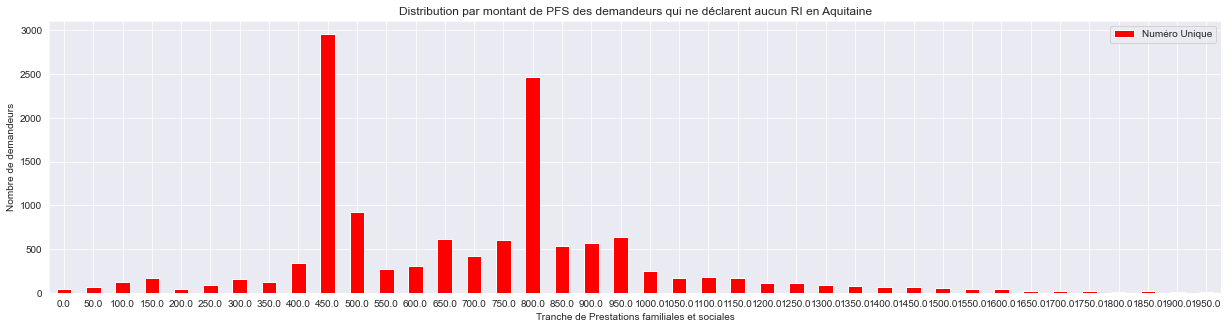

In [370]:
 ax = ri.plot.bar(x='Tranches de PFS', y='Numéro Unique', xlabel='Tranche de Prestations familiales et sociales', ylabel= "Nombre de demandeurs", title= 'Distribution par montant de PFS des demandeurs qui ne déclarent aucun RI en Aquitaine', rot=0, figsize=(21,5), color='red')

In [371]:
ax.figure.savefig('PFS_Aquitaine2.pdf')

### Graphiques PFS nuls

In [372]:
PFS=bddbis[bddbis['Prestations familiales et sociales mensuelles moyennes (PFS)']==0]

In [373]:
PFS['Tranches de RI']=0

def pfs(rl):
    for i in range(0, 2000, 50):
        if i<rl and rl<=i+50:
            return i
        elif rl>2000:
            return np.NaN

PFS['Tranches de RI'] = PFS['Ressources imposables mensuelles moyennes (RI)'].apply(pfs)
PFS

C:\Users\arceb\AppData\Local\Temp\ipykernel_1752\2495171306.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\arceb\AppData\Local\Temp\ipykernel_1752\2495171306.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Numéro Unique,RM Moyennes,Ressources imposables mensuelles moyennes (RI),Prestations familiales et sociales mensuelles moyennes (PFS),Ri + PFS,Tranches de ressources mensuelles (RM),Tranches de RI,Tranches de PFS
3,0010217076033GDPUB,1200.0,1200.0,0.0,1200.0,1200.0,1150.0,NaN
4,001021707620301173,1200.0,1200.0,0.0,1200.0,1200.0,1150.0,NaN
5,001041707857711126,800.0,800.0,0.0,800.0,800.0,750.0,NaN
6,001041707861811126,1526.0,1526.0,0.0,1526.0,1500.0,1500.0,NaN
7,0010417079307GDPUB,1146.0,1146.0,0.0,1146.0,1100.0,1100.0,NaN
...,...,...,...,...,...,...,...,...
80871,9740317140150GDPUB,1579.0,1579.0,0.0,1579.0,1550.0,1550.0,NaN
80875,974111715873511487,1725.0,1725.0,0.0,1725.0,1700.0,1700.0,NaN
80876,9741216133916GDPUB,2000.0,2000.0,0.0,2000.0,2000.0,1950.0,NaN
80877,9741216133920GDPUB,846.0,846.0,0.0,846.0,800.0,800.0,NaN


In [374]:
pfs=PFS[['Tranches de RI', 'Numéro Unique']]
pfs = pfs.groupby(by='Tranches de RI').count()['Numéro Unique']
pfs = pfs.to_frame()

In [375]:
pfs['Numéro Unique'].sum()

41769

In [376]:
pfs=pfs.reset_index()
#pfs['Numéro Unique']=(pfs['Numéro Unique']/61015)*100
pfs

,Tranches de RI,Numéro Unique
0,0.0,74
1,50.0,44
2,100.0,69
3,150.0,72
4,200.0,75
5,250.0,105
6,300.0,117
7,350.0,162
8,400.0,184
9,450.0,874


In [377]:
pfs['Numéro Unique'].sum()

41769

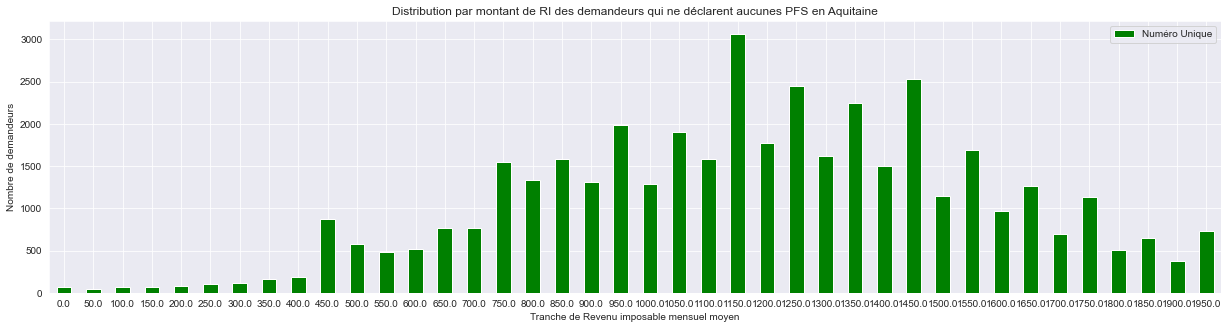

In [378]:
 ax = pfs.plot.bar(x='Tranches de RI', y='Numéro Unique', xlabel='Tranche de Revenu imposable mensuel moyen', ylabel= "Nombre de demandeurs", title= 'Distribution par montant de RI des demandeurs qui ne déclarent aucunes PFS en Aquitaine', rot=0, figsize=(21,5), color='green')

In [379]:
ax.figure.savefig('RI_Aquitaine2.pdf')